In [2]:
import random
from functools import partial

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torchvision import datasets, transforms

# Exercise 1 - MLPs, CNNs and Shift Invariance
Signals and sequences make up many common and interesting forms of data. A signal measures some output quantity as a function of an independent variable. Examples include audio (pressure as a function of time) and images (intensity as a function of direction or distance). Written language can be viewed as an an ordered sequence of symbols (letters or words).

When using a fully connected networks (MLPs) with signals or sequences we form a vector that is then fed into the network. An MLP makes no assumptions about the data, neither about the order / relation between the elements or the meaning of the each input (they could be completely different as can be the case with e.g. tabular data). As a result, an MLP may need to learn to classify signals with different shifts separately (e.g. a slightly shifted image could look completely different to these networks).

Convolutions on the other hand are shift invariant, shifting the input shifts the output by the same amount. This makes convolutions a natural candidate for dealing with signals. The same weights can be used to detect a feature across all locations and features learned in one area should generalize to different locations. As a result, convolutional networks (CNNs) should generally be much more robust to translations/shifts in the input data. Note however, that CNNs are generally not fully shift invariant since they contain other operations such as pooling, padding and potentially fully connected layers at the end.

The goal of this exercise is to explore how MLPs and CNNs respond to shifted inputs.
Our base dataset is going to be MNIST (again, since it is relatively tractible and trains in a short amount of time).
We will explore the performance of each network in three cases:
* The original images.
* Images with an expanded canvas, where an original image is randomly inserted.
* A shuffled version of the original images (with the same shuffling across all images).

The exercise is broken down into several steps:
* Loading and creating the datasets
* Defining the networks
* Writing the training script
* Measuring the performance of each setting (network and data combination)

## Exercise 1.1 - Dataloading
Here we create a modified version of a dataset such as MNIST or FashionMNIST.
Fill in the missing details in get_dataloaders.
You can find the explanations for the missing arguments here:
* [List of vision datasets](https://pytorch.org/vision/stable/datasets.html)
* [torchvision.datasets.MNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST)
* [List of transforms](https://pytorch.org/vision/stable/transforms.html)
* [ToTensor](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#torchvision.transforms.ToTensor)
* [Normalize](https://pytorch.org/vision/stable/generated/torchvision.transforms.Normalize.html#torchvision.transforms.Normalize)
* [Overview of dataloading](https://pytorch.org/docs/stable/data.html)
* [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)

The arguments used for the DataLoaders can affect the speed of training significantly. If the data loading is not fast enough it stalls the training and the GPU/CPU spends a lot of time just waiting for data. For training we want to shuffle the order of the samples in each epoch (not needed for validation), and also use pinned memory when using a GPU for faster transfers. The DataLoader uses multiprocessing, spinning up other processes to load the data, freeing the main process to run the rest of the training script. The ideal number of data worker processes depends on the number of CPU cores available and the computational requirements of data loading. When running this notebook on the free tier Google Colab instances you can set `num_workers=2`.

We will use the test set as a validation set. This is bad practice, you should use a separate portion of the train set as validation set for real projects. In this case it simplifies the implementation and proper validation is not the focus of the exercise.


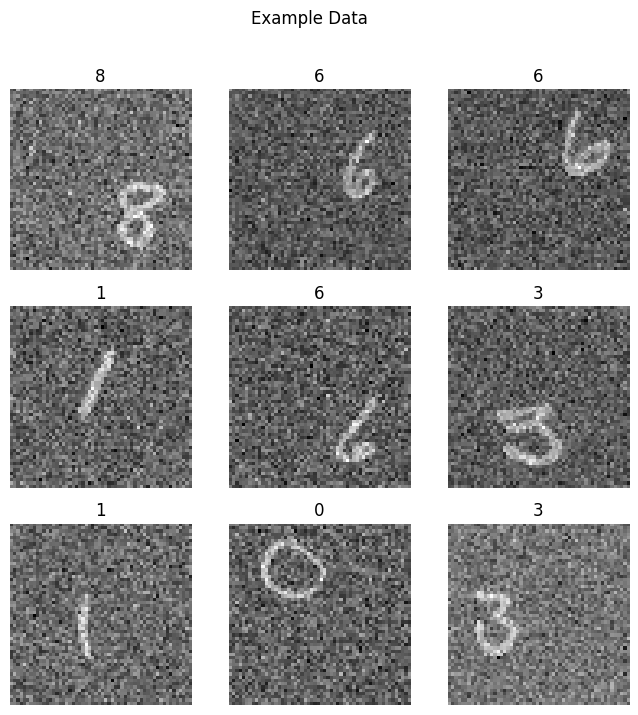

In [43]:
def get_modified_dataset(dataset):
    """
    Return a modified dataset cls that can insert MNIST like images into larger
    frames with an option for random shifts, scrambling the images in a
    consistent way (using the same shuffling for all images) and adding random
    Gaussian noise (to the base data, noise is always the same for a given
    image).
    """

    class ModifiedDataset(dataset):
        def __init__(
            self,
            root,
            img_size=56,
            random_shift=False,
            scramble_image=False,
            noise=0.0,
            *args,
            **kwargs
        ):
            super().__init__(root, *args, **kwargs)
            assert img_size >= 28
            self.img_size = img_size
            self.scramble_image = scramble_image
            assert noise >= 0.0
            self.noise = noise

            if random_shift:
                rng = random.Random(433)
                self.r_idxs = [
                    rng.randrange(img_size - 28 + 1) for _ in range(len(self))
                ]
                self.c_idxs = [
                    rng.randrange(img_size - 28 + 1) for _ in range(len(self))
                ]
            else:
                self.r_idxs = [(img_size - 28) // 2] * len(self)
                self.c_idxs = self.r_idxs
            self.torch_rng = torch.Generator()
            self.torch_rng.manual_seed(2147483647)
            self.shuffle_idxs = torch.randperm(img_size**2, generator=self.torch_rng)

        def __getitem__(self, index):
            sample = super().__getitem__(index)
            image, label = sample

            if self.img_size > 28:
                new_image = torch.full((1, self.img_size, self.img_size), image.min())
                c_idx = self.c_idxs[index]
                r_idx = self.r_idxs[index]
                new_image[:, c_idx : c_idx + 28, r_idx : r_idx + 28] = image
                image = new_image

            if self.noise:
                self.torch_rng.manual_seed(2147433433 + index)
                image = image + self.noise * torch.randn(
                    image.shape, generator=self.torch_rng
                )

            if self.scramble_image:
                image = image.view(-1)[self.shuffle_idxs].reshape(
                    1, self.img_size, self.img_size
                )

            return (image, label)

    return ModifiedDataset


def get_dataloaders(
    base_dataset,
    batch_size,
    img_size=28,
    random_shift=False,
    scramble_image=False,
    noise=0.0,
    show_examples=False,
):
    dataset_cls = get_modified_dataset(base_dataset)
    if base_dataset == datasets.FashionMNIST:
        mean = 0.286041
        std = 0.353024
        labels_map = lambda label: {
            0: "T-Shirt",
            1: "Trouser",
            2: "Pullover",
            3: "Dress",
            4: "Coat",
            5: "Sandal",
            6: "Shirt",
            7: "Sneaker",
            8: "Bag",
            9: "Ankle Boot",
        }[label]
        path = "./data/FMNIST/"
    elif base_dataset == datasets.MNIST:
        mean = 0.1307
        std = 0.3081
        labels_map = lambda label: label
        path = "./data/MNIST/"
    else:
        raise NotImplementedError

    ### SOLUTION
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((mean,), (std,))]
    )
    train_set = dataset_cls(
        path,
        train=True,
        download=True,
        transform=transform,
        img_size=img_size,
        random_shift=random_shift,
        scramble_image=scramble_image,
        noise=noise,
    )
    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,  # Shuffle the iteration order over the dataset
        pin_memory=torch.cuda.is_available(),
        drop_last=False,
        num_workers=2,
    )

    val_set = dataset_cls(
        path,
        train=False,
        download=True,
        transform=transform,
        img_size=img_size,
        random_shift=random_shift,
        scramble_image=scramble_image,
        noise=noise,
    )
    val_loader = torch.utils.data.DataLoader(
        val_set,
        batch_size=batch_size,
        shuffle=False,
    )
    ### TEMPLATE
    # # ***************************************************
    # # INSERT YOUR CODE HERE
    # # TODO: Create the datasets and dataloaders with the
    # # right arguments
    # # ***************************************************
    # transform = transforms.Compose([
    # # TODO: Insert ToTensor and Normalize using mean and std.
    # # We can use the same transforms for train and val since we don't perform
    # # any augmentations.
    # ])
    # train_set = dataset_cls(
    # # TODO: Add the appropriate arguments
    # )
    # train_loader = torch.utils.data.DataLoader(
    # # TODO: Add the appropriate arguments
    # )
    # val_set = dataset_cls(
    # # TODO: Add the appropriate arguments
    # )
    # val_loader = torch.utils.data.DataLoader(
    # # TODO: Add the appropriate arguments
    # )
    # raise NotImplementedError
    ### END SOLUTION

    if show_examples:
        figure = plt.figure(figsize=(8, 8))
        figure.suptitle("Example Data")
        cols, rows = 3, 3
        for i in range(1, cols * rows + 1):
            sample_idx = torch.randint(len(train_set), size=(1,)).item()
            img, label = train_set[sample_idx]
            figure.add_subplot(rows, cols, i)
            plt.title(labels_map(label))
            plt.axis("off")
            plt.imshow(img.squeeze(), cmap="gray")
        plt.show()
    return train_loader, val_loader


# Small test and visualization of the data
temp = get_dataloaders(
    datasets.MNIST,
    batch_size=32,
    img_size=56,
    random_shift=True,
    scramble_image=False,
    noise=1.0,
    show_examples=True,
)
del temp

## Exercise 1.2 - Model Definition
Fill in the code below to define the two models. The models take in batches of dimensions N,C,H,W. The model descriptions are given below.

MLP:
* Flatten the image to a vector [hint](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html#torch.nn.Flatten)
* Fully connected layer from image_size**2 to 256 [hint](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)
* ReLU [hint](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)
* Fully connected 256 -> 256
* ReLU
* Fully connected 256 -> 256
* ReLU
* Fully connected 256 -> 256
* ReLU
* Fully connected 256 -> 10

CNN:
* Convolution, 1 -> 32 channels, kernel size of 5, zero padding for same output size [hint](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
* ReLU
* Convolution, 32 -> 64 channels, kernel size of 5, zero padding of 2, stride of 2
* ReLU
* Convolution, 64 -> 64 channels, kernel size of 5, zero padding for same output size
* ReLU
* Convolution, 64 -> 128 channels, kernel size of 5, zero padding of 2, stride of 2
* ReLU
* Average Pooling to make the output height and width 1 [hint](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d)
* Convolution, 128 -> 10, kernel size of 1
* Flatten to get N,10 for classification

Note that the last convolution performs a role equivalent to a fully connected layer.

In [44]:
input = torch.randn(32, 1, 5, 5)
# With default parameters
print(input.size())
m = nn.Flatten()
output = m(input)
output.size()

torch.Size([32, 1, 5, 5])


torch.Size([32, 25])

In [45]:
# ***************************************************
# INSERT YOUR CODE HERE
# ***************************************************
get_mlp = lambda image_size: torch.nn.Sequential(
    # TODO: Insert the appropriate arguments here
    nn.Flatten(),
    nn.Linear(in_features=image_size**2, out_features=256), 
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=256), 
    nn.ReLU(), 
    nn.Linear(in_features=256, out_features=256), 
    nn.ReLU(), 
    nn.Linear(in_features=256, out_features=256), 
    nn.ReLU(), 
    nn.Linear(in_features=256, out_features=10), 

)

get_cnn = lambda image_size: torch.nn.Sequential(
    # TODO: Insert the appropriate arguments here, 
    nn.Conv2d(1, 32, 5, padding=2), 
    nn.ReLU(), 
    nn.Conv2d(32, 64, 5, padding=2, stride=2), 
    nn.ReLU(), 
    nn.Conv2d(64, 64, 5, padding=2), 
    nn.ReLU(), 
    nn.Conv2d(64, 128, 5, padding=2, stride=2), 
    nn.ReLU(), 
    nn.AvgPool2d(1,1), 
    nn.Conv2d(128, 10 , 1), 
    nn.Flatten(), 
)

## Exercise 1.3 - Training Loop
In this portion we write a training loop to train the model.
This is largely boilerplate code and we use a very similar implementation as last week.
We still believe it is a good exercise for you to review and reimplement it since you will encounter this every time you train a neural network in PyTorch.
You can refer to last week's solution or the validate function if you need hints.

This time we add a learning rate schedule and more hyperparameters for the optimizer. We use [AdamW](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html#torch.optim.AdamW), a variant of Adam that uses a different form of weight decay that is usually more effective than standard Adam. AdamW is one of the most commonly used optimizers today. We also use a [Cosine Decay learning rate schedule](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html#torch.optim.lr_scheduler.CosineAnnealingLR) which is a good default schedule and the likely the first one you should try in your own projects.

In [62]:
def train_epoch(model, optimizer, scheduler, criterion, train_loader, epoch, device):
    # ***************************************************
    # TODO: FILL IN THE DETAILS BELOW
    # ***************************************************
    # TODO: Set model to training mode (affects dropout, batch norm e.g.)
    loss_history = []
    accuracy_history = []
    lr_history = []
    # TODO: Change the loop to get batch_idx, data and target from train_loader
    for batch_idx, (data, target) in enumerate(train_loader):
        # TODO: Move the data to the device
        data, target = data.to(device), target.to(device)
        # TODO: Zero the gradients
        optimizer.zero_grad()
        # TODO: Compute model output
        output = model(data)
        # print('output', output.size())
        # print('target', target.size())
        # TODO: Compute loss
        loss = criterion(output, target)
        # TODO: Backpropagate loss
        loss.backward()
        # TODO: Perform an optimizer step
        optimizer.step()
        # TODO: Perform a learning rate scheduler step
        scheduler.step()

        # pred = output.argmax(dim = 1)

        # # TODO: Compute accuracy_float (float value, not a tensor)
        # accuracy_float = torch.sum(pred == target).cpu() / len(pred)

        pred = output.argmax(dim=1, keepdim=True)
        correct = pred.eq(target.view_as(pred)).sum().item()
        accuracy_float = correct / len(data)
        loss_float = loss.item()
        # TODO: Compute loss_float (float value, not a tensor)
        # TODO: Add loss_float to loss_history
        loss_history.append(loss_float)
        # TODO: Add accuracy_float to accuracy_history
        accuracy_history.append(accuracy_float)

        lr_history.append(scheduler.get_last_lr()[0])
        
        if batch_idx % (len(train_loader.dataset) // len(data) // 10) == 0:
            print(
                f"Train Epoch: {epoch}-{batch_idx:03d} "
                f"batch_loss={loss_float:0.2e} "
                f"batch_acc={accuracy_float:0.3f} "
                f"lr={scheduler.get_last_lr()[0]:0.3e} "
            )

    return loss_history, accuracy_history, lr_history


@torch.no_grad()
def validate(model, device, val_loader, criterion):
    model.eval()  # Important: eval mode (affects dropout, batch norm etc)
    test_loss = 0
    correct = 0
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item() * len(data)
        pred = output.argmax(
            dim=1, keepdim=True
        )  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(val_loader.dataset)

    print(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)".format(
            test_loss,
            correct,
            len(val_loader.dataset),
            100.0 * correct / len(val_loader.dataset),
        )
    )
    return float(test_loss), float(correct / len(val_loader.dataset))


@torch.no_grad()
def get_predictions(model, device, val_loader, criterion, num=None):
    model.eval()
    points = []
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        pred = output.argmax(dim=1, keepdim=True)

        data = np.split(data.cpu().numpy(), len(data))
        loss = np.split(loss.cpu().numpy(), len(data))
        pred = np.split(pred.cpu().numpy(), len(data))
        target = np.split(target.cpu().numpy(), len(data))
        points.extend(zip(data, loss, pred, target))

        if num is not None and len(points) > num:
            break

    return points


def run_training(
    model_factory,
    num_epochs,
    optimizer_kwargs,
    data_kwargs,
    device="cuda",
):
    # ===== Data Loading =====
    train_loader, val_loader = get_dataloaders(**data_kwargs)

    # ===== Model, Optimizer and Criterion =====
    model = model_factory()
    model = model.to(device=device)
    optimizer = torch.optim.AdamW(model.parameters(), **optimizer_kwargs)
    criterion = torch.nn.functional.cross_entropy
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=(len(train_loader.dataset) * num_epochs) // train_loader.batch_size,
    )

    # ===== Train Model =====
    lr_history = []
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc, lrs = train_epoch(
            model, optimizer, scheduler, criterion, train_loader, epoch, device
        )
        train_loss_history.extend(train_loss)
        train_acc_history.extend(train_acc)
        lr_history.extend(lrs)

        val_loss, val_acc = validate(model, device, val_loader, criterion)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

    # ===== Plot training curves =====
    n_train = len(train_acc_history)
    t_train = num_epochs * np.arange(n_train) / n_train
    t_val = np.arange(1, num_epochs + 1)

    plt.figure(figsize=(6.4 * 3, 4.8))
    plt.subplot(1, 3, 1)
    plt.plot(t_train, train_acc_history, label="Train")
    plt.plot(t_val, val_acc_history, label="Val")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.subplot(1, 3, 2)
    plt.plot(t_train, train_loss_history, label="Train")
    plt.plot(t_val, val_loss_history, label="Val")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1, 3, 3)
    plt.plot(t_train, lr_history)
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")

    # ===== Plot low/high loss predictions on validation set =====
    points = get_predictions(
        model,
        device,
        val_loader,
        partial(torch.nn.functional.cross_entropy, reduction="none"),
    )
    points.sort(key=lambda x: x[1])
    plt.figure(figsize=(15, 6))
    for k in range(5):
        plt.subplot(2, 5, k + 1)
        plt.imshow(points[k][0][0, 0], cmap="gray")
        plt.title(f"true={int(points[k][3])} pred={int(points[k][2])}")
        plt.subplot(2, 5, 5 + k + 1)
        plt.imshow(points[-k - 1][0][0, 0], cmap="gray")
        plt.title(f"true={int(points[-k-1][3])} pred={int(points[-k-1][2])}")

    return sum(train_acc) / len(train_acc), val_acc

## Exercise 1.4 - Running the Experiments
Run both the MLP and the CNN on the three configurations:
* Baseline: Centered, unscrambled data
* Randomly shifted, unscrambled data
* Centered, scrambled data

We add Gaussian Noise with zero mean and unit variance in all cases.

How does the CNN and MLP perform in each case. In particular:
* To what extent does random shifting affect the MLP vs CNN?
* To what extent does scrambling affect the MLP vs CNN?

Note that to be scientifically rigorous, the hyperparameters should be tuned in each setting but we don't expect you to do this here. We used the following hyperparameters in each network (not significantly tuned).

MLP:
* lr=1e-3
* weight_decay=1e-2
* num_epochs=5

CNN:
* lr=5e-4
* weight_decay=1e-3
* num_epochs=5


device cuda


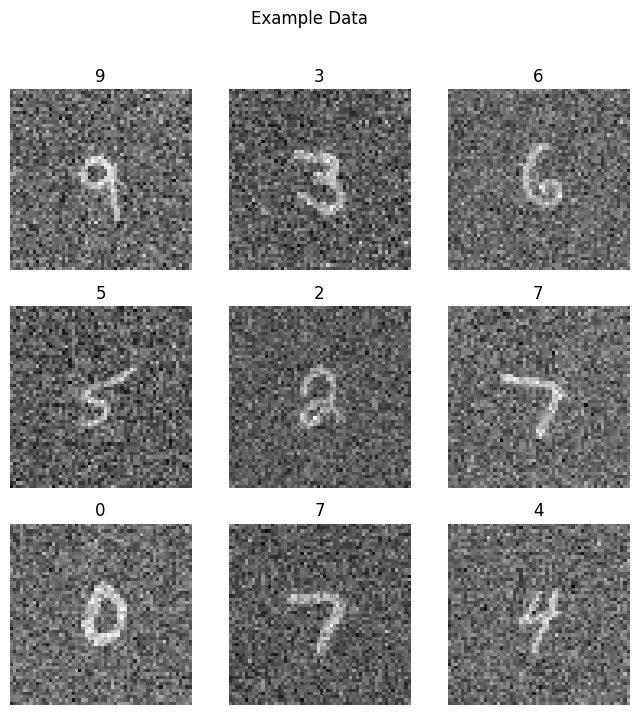

Train Epoch: 1-000 batch_loss=2.30e+00 batch_acc=0.102 lr=1.000e-03 
Train Epoch: 1-046 batch_loss=6.56e-01 batch_acc=0.805 lr=9.990e-04 
Train Epoch: 1-092 batch_loss=3.95e-01 batch_acc=0.891 lr=9.961e-04 
Train Epoch: 1-138 batch_loss=2.95e-01 batch_acc=0.906 lr=9.913e-04 
Train Epoch: 1-184 batch_loss=3.87e-01 batch_acc=0.898 lr=9.847e-04 
Train Epoch: 1-230 batch_loss=4.10e-01 batch_acc=0.867 lr=9.762e-04 
Train Epoch: 1-276 batch_loss=3.09e-01 batch_acc=0.906 lr=9.659e-04 
Train Epoch: 1-322 batch_loss=2.53e-01 batch_acc=0.891 lr=9.538e-04 
Train Epoch: 1-368 batch_loss=4.46e-01 batch_acc=0.836 lr=9.400e-04 
Train Epoch: 1-414 batch_loss=2.53e-01 batch_acc=0.914 lr=9.246e-04 
Train Epoch: 1-460 batch_loss=2.27e-01 batch_acc=0.930 lr=9.075e-04 
Test set: Average loss: 0.2672, Accuracy: 9153/10000 (92%)
Train Epoch: 2-000 batch_loss=1.05e-01 batch_acc=0.977 lr=9.040e-04 
Train Epoch: 2-046 batch_loss=1.24e-01 batch_acc=0.953 lr=8.850e-04 
Train Epoch: 2-092 batch_loss=1.33e-01 batch

(0.9997001599147122, 0.9359)

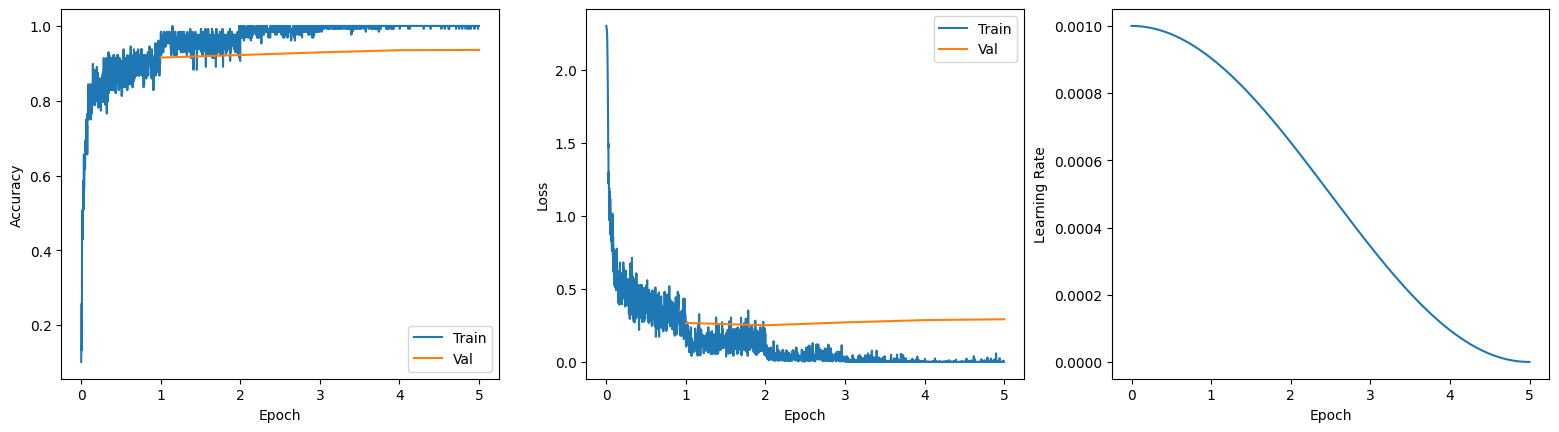

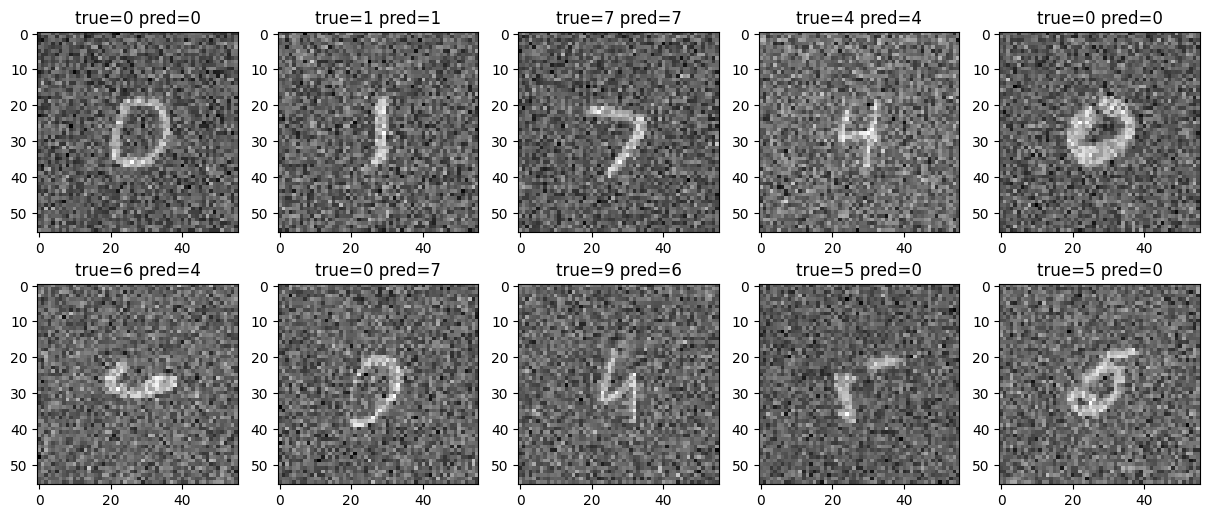

In [63]:
image_size = 56
model_factory = lambda: get_mlp(image_size)
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('device', device)

optimizer_kwargs = dict(
    lr=1e-3,
    weight_decay=1e-2,
)
data_kwargs = dict(
    base_dataset=datasets.MNIST,
    batch_size=128,
    img_size=image_size,
    random_shift=False,
    scramble_image=False,
    noise=1.0,
    show_examples=True,
)

run_training(
    model_factory=model_factory,
    num_epochs=num_epochs,
    optimizer_kwargs=optimizer_kwargs,
    data_kwargs=data_kwargs,
    device=device,
)

# Exercise 2 - Residual Connections and Network Depth
Adding more layers to a network should generally increase its representation power (assuming the later layers are able to learn an identity function), leading to a lower training loss. However, this is not always the case as observed in the original [ResNet paper](https://arxiv.org/abs/1512.03385). Skip connections make deeper networks easier to train.

In this excercise you will build a simple residual network inspired by the CIFAR10 version of the original ResNet.

We will reuse the training script and data from the previous exercise except for the slightly harder FashionMNIST dataset. This dataset has 10 catagories corresponding to different forms of clothing but the same grayscale 28x28 format as MNIST.

## Exercise 2.1 - Model Definition
ResNet consists of blocks of several convolutions with a skip connection around them. It also has special input and output layers that do not follow the block structure.

There exist various forms of residual blocks with a different number and configuration for the convolutions. Some blocks start with a strided convolution and/or a convolution which has a different number of output channels than input channels. In those cases the dimensions of the skip connection don't match the output of the residual. To fix this we add a convolution to the skip connection that changes the output dimensions in the same way.

Residual Block:
* Has the following components:
  * Convolutions C1 and C2
  * Batch normalization layers: N1 and N2
  * ReLUs: R1 and R2
When C1 changes the output shape (i.e. if it has `stride != 1` or `in_channels != out_channels`) we additionally have C3, N3 with the same configuration as C1 and N1. We add C3 and N3 to the skip connection (which is no longer a proper skip connection).
* The residual connection has the following structure: `Residual(x)=N2(C2(R1(N1(C1(x)))))`
* The skip connection is either `Skip(x)=x` or `Skip(x)=N3(C3(x))`
* The output of the block is `R2(Residual(x) + Skip(x))`

Fill in the missing details in the StandardBlock class below. We provide the code for a non-residual block with the same configuration for reference. NonResidualBlock could also be implemented with torch.nn.Sequential unlike the ResidualBlock. Note that the classes inherit from `torch.nn.Module` and contains other modules like convolutional layers. The blocks can be added to Sequential containers to get a full model.

In [80]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        # TODO: Create C1, C2, N1, N2, R1, R2
        self.C1 = torch.nn.Conv2d(in_channels, out_channels, 3, stride, padding = 1)
        self.N1 = torch.nn.BatchNorm2d(num_features=out_channels)
        self.R1 = torch.nn.ReLU()
        self.C2 = torch.nn.Conv2d(out_channels, out_channels, 3, stride, padding = 1)
        self.N2 = torch.nn.BatchNorm2d(num_features=out_channels)
        self.R2 = torch.nn.ReLU()

        self.has_skip_conv = stride != 0 or in_channels != out_channels
        if self.has_skip_conv:
            # TODO: Define C3 and N3
            self.C3 = torch.nn.Conv2d(in_channels, out_channels, 3, stride, padding = 1)
            self.N3 = torch.nn.BatchNorm2d(num_features=out_channels)

    def forward(self, x):
        # ***************************************************
        # TODO: IMPLEMENT THE FWD PASS
        # ***************************************************
        skip_x = x

        x = self.C1(x)
        x = self.N1(x)
        x = self.R1(x)
        x = self.C2(x)
        x = self.N2(x)
        if self.has_skip_conv:
            skip_x = self.C3(skip_x)
            skip_x = self.N3(skip_x)

        return self.R2(x + skip_x)


class NonResidualBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.C1 = torch.nn.Conv2d(
            in_channels,
            out_channels,
            3,
            stride=stride,
            padding=1,
        )
        self.N1 = torch.nn.BatchNorm2d(num_features=out_channels)
        self.R1 = torch.nn.ReLU()
        self.C2 = torch.nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.N2 = torch.nn.BatchNorm2d(num_features=out_channels)
        self.R2 = torch.nn.ReLU()

    def forward(self, x):
        x = self.C1(x)
        x = self.N1(x)
        x = self.R1(x)
        x = self.C2(x)
        x = self.N2(x)
        x = self.R2(x)
        return x


def get_model(depth, block_type="ResidualBlock", base_width=16):
    if block_type == "ResidualBlock":
        block_factory = ResidualBlock
    elif block_type == "NonResidualBlock":
        block_factory = NonResidualBlock
    else:
        raise ValueError()

    # Input layers
    modules = [
        torch.nn.Conv2d(1, base_width, 3, padding=1),
        torch.nn.BatchNorm2d(base_width),
        torch.nn.ReLU(),
    ]

    # Blocks and stages (based off the configuration used in the ResNet paper)
    blocks_per_stage = (depth - 2) // 6
    assert depth == blocks_per_stage * 6 + 2
    in_channels = base_width
    out_channels = base_width
    for stage_idx in range(3):
        for block_idx in range(blocks_per_stage):
            stride = 2 if block_idx == 0 and stage_idx > 0 else 1
            modules.append(
                block_factory(
                    in_channels,
                    out_channels,
                    stride,
                )
            )
            in_channels = out_channels
        out_channels = out_channels * 2

    # Output layers
    modules.extend(
        [
            torch.nn.AdaptiveAvgPool2d(1),
            torch.nn.Flatten(),
            torch.nn.Linear(in_channels, 10),
        ]
    )

    model = torch.nn.Sequential(*modules)
    print(f"Model:\n {model}")
    return model

## Exercise 2.2 - Training the model
Train your ResNet using the cell below. We use the following hyperparameters:
* lr=0.003
* weight_decay=0.001
* num_epochs=10

You should see around 93% validation accuracy using these hyperparameters (within 1%).

Note that you can also experiment with the non-residual block but this dataset might not be too easy to observe a large difference in the performance. For more complicated datasets there can be significant difference.

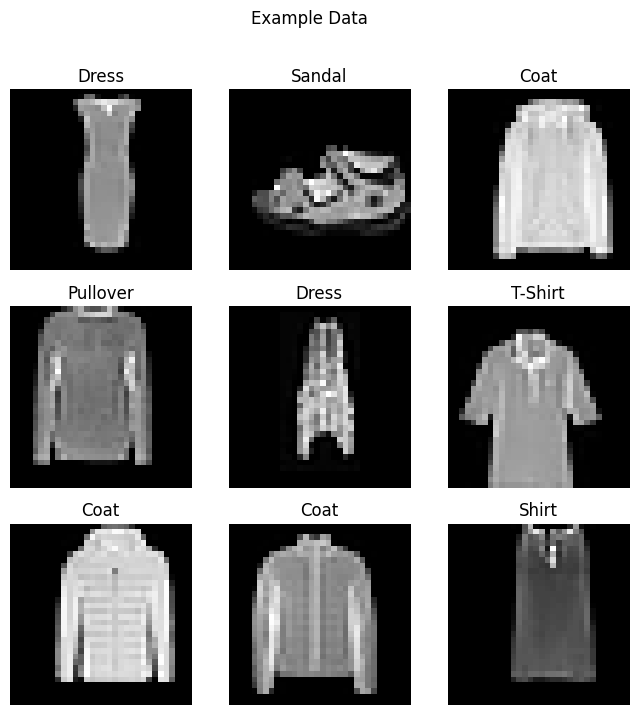

Model:
 Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): ResidualBlock(
    (C1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (N1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (R1): ReLU()
    (C2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (N2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (R2): ReLU()
    (C3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (N3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): ResidualBlock(
    (C1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (N1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (R1): ReLU()
    (C2): Conv2d(16, 16, kernel_size=(3, 3),

(0.8761660447761194, 0.8686)

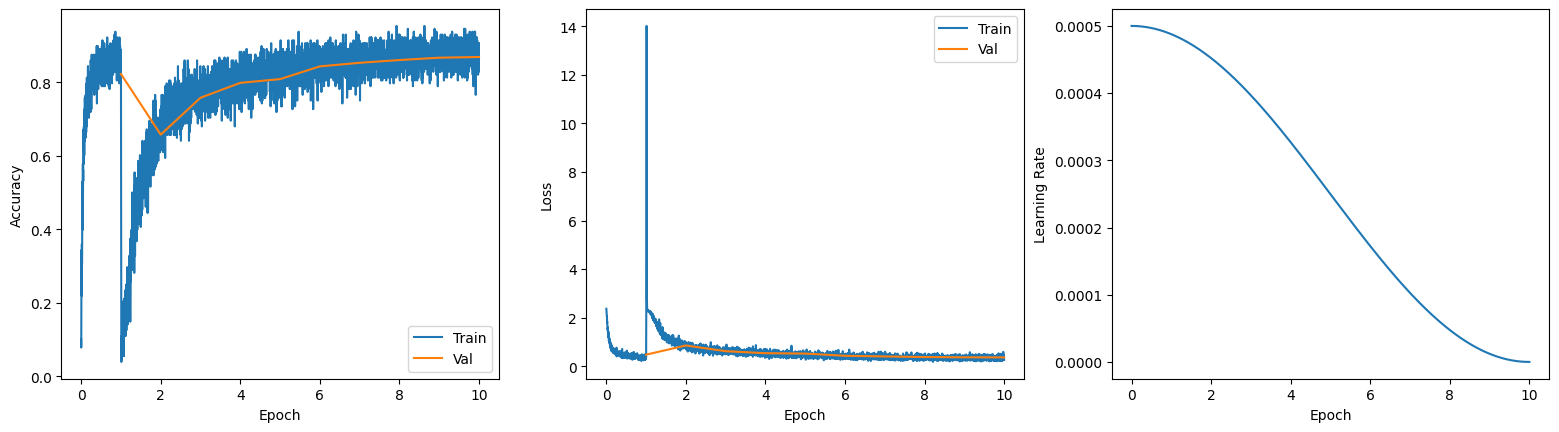

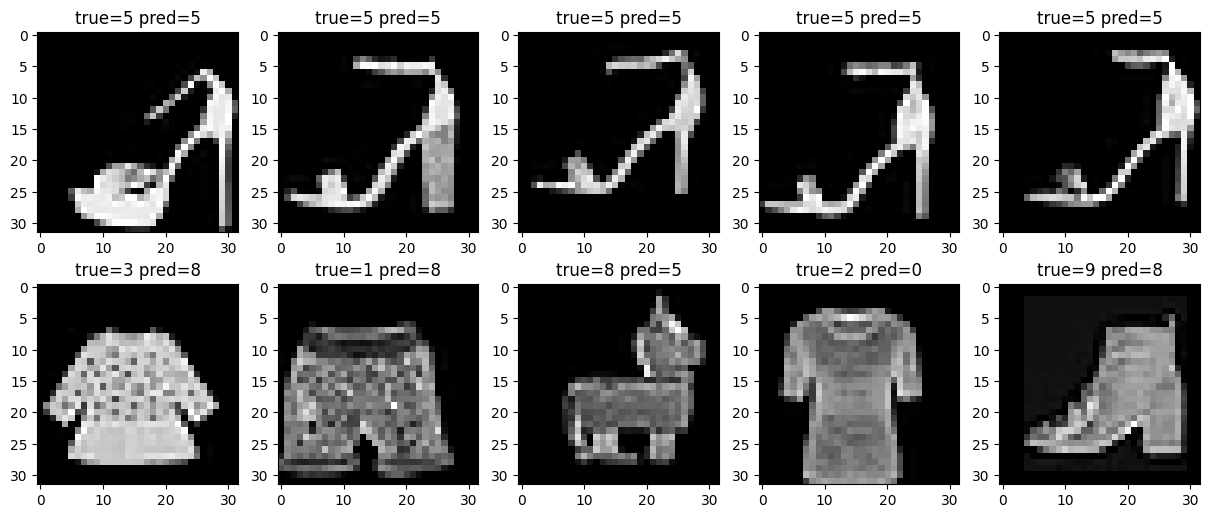

In [81]:
optimizer_kwargs = dict(
    lr=5e-4,
    weight_decay=1e-3,
)
num_epochs = 10


image_size = 32
model_factory = lambda: get_model(20, "ResidualBlock")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_kwargs = dict(
    base_dataset=datasets.FashionMNIST,
    batch_size=128,
    img_size=image_size,
    random_shift=True,
    scramble_image=False,
    noise=0.0,
    show_examples=True,
)

run_training(
    model_factory=model_factory,
    num_epochs=num_epochs,
    optimizer_kwargs=optimizer_kwargs,
    data_kwargs=data_kwargs,
    device=device,
)